In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools

from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

In [69]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz

In [3]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [174]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = instools.create_inst(IVVI, "ivvi", "ASRL5::INSTR")

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = instools.create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0101::MY57503556::INSTR")
key2 = instools.create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR")

from qcodes.instrument_drivers.stanford_research.SR860 import SR860

lockin1 = instools.create_inst(SR860, "lockin1", "GPIB0::3::INSTR")
lockin2 = instools.create_inst(SR860, "lockin2", "GPIB0::4::INSTR")

station = qc.Station(ivvi, key1, key2, lockin1, lockin2)

Instrument ivvi already exists.
Instrument key1 already exists.
Instrument key2 already exists.
Instrument lockin1 already exists.
Instrument lockin2 already exists.


In [627]:
def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def process_data(bias, current, voltage, R, smooth_win=50, V_ratio=1e-3):    
    bias    = bias * (V_ratio/1e-3)
    voltage = voltage * 1e6
    current = current * 1e9
    voltage -= voltage.mean()
    current -= current[current.size//2]

    
    iof, bof = find_offset(current, bias, smooth_win=smooth_win)
    # print(iof, bof)
    bias = bias - bof
    bias -= current * R * 1e-3

    _, vof = find_offset(current, voltage, smooth_win=smooth_win)
    voltage -= vof
    # current -= iof
    print(vof)
    
    return bias, current, voltage


def find_offset(i, v, i_th=0.1, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win), fill_value='extrapolate')
    v_guess = v[np.argmin(abs(i-i_th))] 
    # print(v_guess)
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):
        print(k, v_of, i_of)
        
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = v_of + (v_pos+v_neg)/2.
        
        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
        
        return i_of, v_of
    

def fit_linslope(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(np.log(i2[i2>0]), v2[i2>0], 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope


def fit_tunnelres(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(v2[i2>0], i2[i2>0],  1)
    i_fit = np.polyval(p, v2)
    r_fit = 1./p[0]
    
    return v2, i_fit, r_fit

In [720]:
station.ivvi.set_dacs_zero()

In [680]:
station.ivvi.dac1(200)

In [583]:
@getter([('voltage', 'V'), ('current', 'A')])
def measure_keys():
    time.sleep(0.02 * key1.NPLC()) 
    voltage = key2.volt()
    current = key1.volt()
    result = voltage/200, current * 1e-7
    return result

@getter([('voltage', 'V'), ('current', 'A'), ('L1X', 'V'), ('L1Y', 'V'), ('L2X', 'V'), ('L2Y', 'V')])
def measure_dc(gain_Imeas=1e6, gain_Vmeas=200):
    time.sleep(.3 * key1.NPLC()) 
    voltage = key2.volt()
    current = key1.volt()
    L1X     = lockin1.X()
    L1Y     = lockin1.Y()
    L2X     = lockin2.X()
    L2Y     = lockin2.Y()
    result  = voltage/gain_Vmeas, current/gain_Imeas, L1X/gain_Imeas, L1Y/gain_Imeas, L2X/gain_Vmeas, L2Y/gain_Vmeas
    return result

<IPython.core.display.Javascript object>


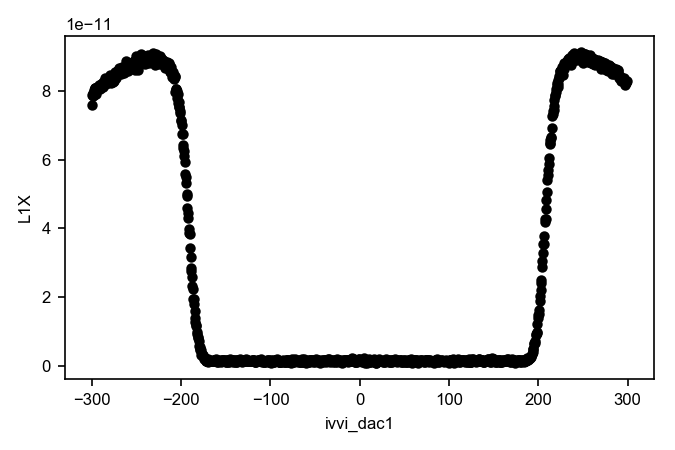

Starting experimental run with id: 82
Completed measurement. Database path: NIS-Thermometer/NISMar18_right/43


In [715]:
setup = [(lambda: None, tuple())]
cleanup = [(lambda: None, tuple())]

key1.NPLC(1)
key2.NPLC(1)

g_bias = 1e-3
lockin1.amplitude(2.5*1e-6/(np.sqrt(2)*1e-2*g_bias))
lockin1.frequency(18.3)
lockin1.time_constant(.1)

result = do_experiment(
#     "NIS-Thermometer/SIM_10k",
    "NIS-Thermometer/NISMar18_right",
    setup,
    nest(
#         sweep(lockin1.frequency, np.linspace(1,60,401)),
        sweep(ivvi.dac1, np.linspace(-300, 300, 1201)),
        measure_dc
    ),
    cleanup,
    return_format=["data_set_path", "dataset"], 
    live_plot_axes=[{"ivvi_dac1": 0, "L1X": 3}]
)

0 0 0
0 0 0
[ 6.12801365]
45733.904875


<IPython.core.display.Javascript object>


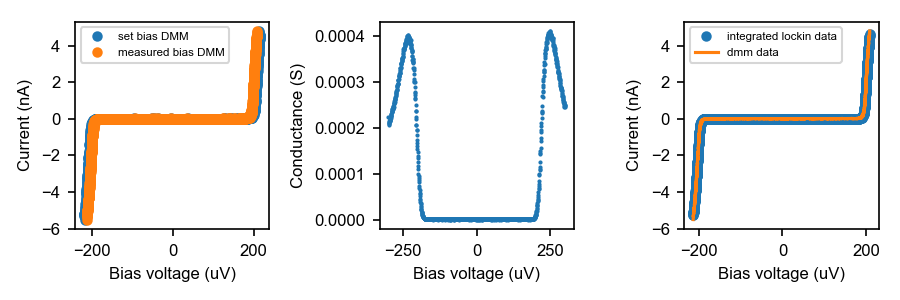

In [716]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id

b = np.array(dv.get_values('ivvi_dac1'))[:,0]
i = np.array(dv.get_values('current'))[:,0]
v = np.array(dv.get_values('voltage'))[:,0]
l1x = np.array(dv.get_values('L1X'))[:,0]
l1y = np.array(dv.get_values('L1Y'))[:,0]
l2x = np.array(dv.get_values('L2X'))[:,0]
l2y = np.array(dv.get_values('L2Y'))[:,0]

dI = (l1x**2+l1y**2)**.5
dV = (l2x**2+l2y**2)**.5

R = 3e3 + 2*(5e3  + 1.7e3)
dIdV = ((l1x**2+l1y**2)**.5/(5*1e-6))
b2, i2, v2 = process_data(b, i, v, R, smooth_win=10, V_ratio=1e-3)

print(1./dIdV[-1]-12e3)

# dummy = 1./(1./dIdV-R)
dummy = dI/dV
dummy -= np.average(dummy[dummy.size//2-30:dummy.size//2+30])
I_sr = cumtrapz(dummy, v) * 1e9
I_sr -= I_sr[I_sr.size//2]

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(6, 2))

ax1.plot(b2, i2, 'o',label="set bias DMM")
ax1.plot(v2, i2, 'o', label="measured bias DMM")
ax1.legend(loc='upper left', fontsize='x-small')
ax1.set_xlabel('Bias voltage (uV)')
ax1.set_ylabel('Current (nA)')
# ax1.plot(v[1:]*1e6, I_sr  + i[0] , 'o') 


# ax1.plot(v[1:]*1e6, I_sr4  + i[0] , 'o') 
# ax1.plot(vlfit4*1e6, ilfit4  + i[0])

# ax2.plot(b, l1x, 'o')
# ax2.plot(b, l1y, 'o')
# ax2.axhline(y=1./R)
# ax2.plot(b, dummy)
# ax2.plot(b, dIdV)
ax2.plot(b, dI/dV,'o', ms=1)
# ax2.set_ylim(-7.5e3,5e3)
ax2.set_ylabel('Conductance (S)')
ax2.set_xlabel('Bias voltage (uV)')

# ax2.plot(v, dIdV, 'o')

ax3.plot(v2[1:], I_sr, 'o', label='integrated lockin data')
ax3.plot(v2, i2, label='dmm data')
ax3.set_xlabel('Bias voltage (uV)')
ax3.set_ylabel('Current (nA)')
ax3.legend(loc='upper left', fontsize='x-small')
# ax3.plot(v, dI/dV, 'o')
# ax3.axhline(y=1e-5, color='green')

fig.tight_layout()



0 0 0
0 0 0
[ 4.8209168]


<IPython.core.display.Javascript object>


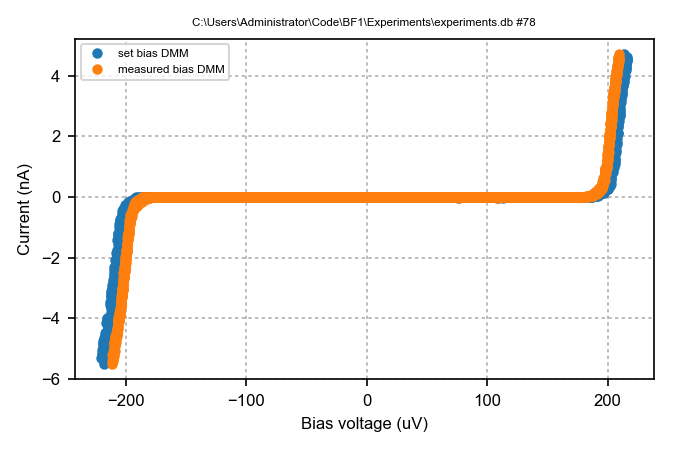

In [696]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id


b = np.array(dv.get_values('ivvi_dac1'))[:,0]
i = np.array(dv.get_values('current'))[:,0]
v = np.array(dv.get_values('voltage'))[:,0]

R = 3e3 + 2*(5e3  + 1.7e3) * 1

b2, i2, v2 = process_data(b, i, v, R, smooth_win=10, V_ratio=1e-3)

fig, ax = plt.subplots(1, 1)
# ax.plot((b*1e-7 - i*R) * 1e6, i * 1e9, 'o')
# ax.plot(v * 1e6, i * 1e9, 'o')
ax.plot(b2, i2, 'o', label="set bias DMM")
ax.plot(v2, i2, 'o', label="measured bias DMM")
# ax.set_yscale('log')
ax.set_xlabel('Bias voltage (uV)')
ax.set_ylabel('Current (nA)')
# ax.set_xlim(0, None)
# ax.set_ylim(1e-4, 1)
ax.set_title(ds_title(dataid), size='x-small')
ax.grid(dashes=[2,2])
ax.legend(loc='upper left', fontsize='x-small')
fig.tight_layout()

basepath = img_basepath(dataid)
if not os.path.exists(os.path.split(basepath)[0]):
    os.makedirs(os.path.split(basepath)[0])
fig.savefig(basepath + '.png', dpi=300)

<IPython.core.display.Javascript object>


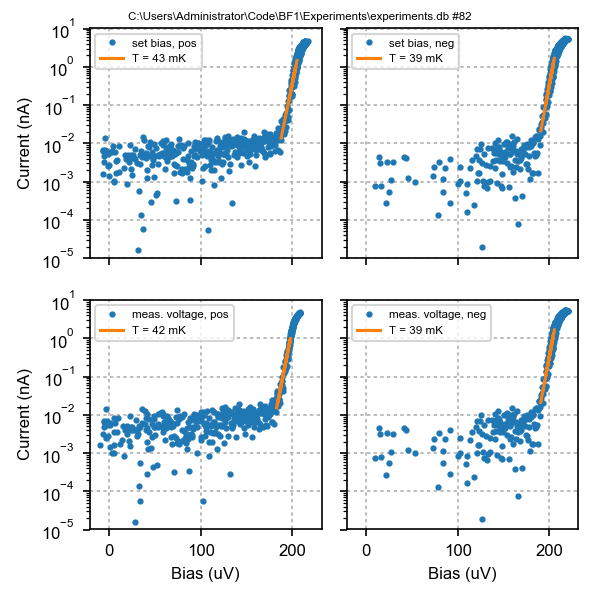

In [717]:
b_plus = b2[b2.size//2:]
b_minus = -b2[:b2.size//2]
v_plus = v2[v2.size//2:]
v_minus = -v2[:v2.size//2]
i_plus = i2[i2.size//2:]
i_minus = -i2[:i2.size//2]
labels = ['set bias, pos', 'set bias, neg', 'meas. voltage, pos', 'meas. voltage, neg']

fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

for i, v, ax, lbl in zip([i_plus, i_minus]*2, [b_plus, b_minus, v_plus, b_minus], axes.reshape(-1), labels):
    fitv, fiti, T = fit_linslope(i, v, ilim=(0.03, 1))
    ax.plot(v, i, 'o', ms=2, label=lbl)
    ax.plot(fitv, fiti, '-', label=f'T = {T*1e3:.0f} mK')
    ax.legend(loc='upper left', fontsize='x-small')
    
    ax.set_yscale('log')
    ax.grid(dashes=[2,2])
    
axes[0,0].set_ylabel('Current (nA)')
axes[1,0].set_ylabel('Current (nA)')
axes[1,0].set_xlabel('Bias (uV)')
axes[1,1].set_xlabel('Bias (uV)')

fig.suptitle(ds_title(dataid), size='x-small')
fig.tight_layout()

basepath = img_basepath(dataid)
if not os.path.exists(os.path.split(basepath)[0]):
    os.makedirs(os.path.split(basepath)[0])
fig.savefig(basepath + 'fit_all.png', dpi=300)

<IPython.core.display.Javascript object>


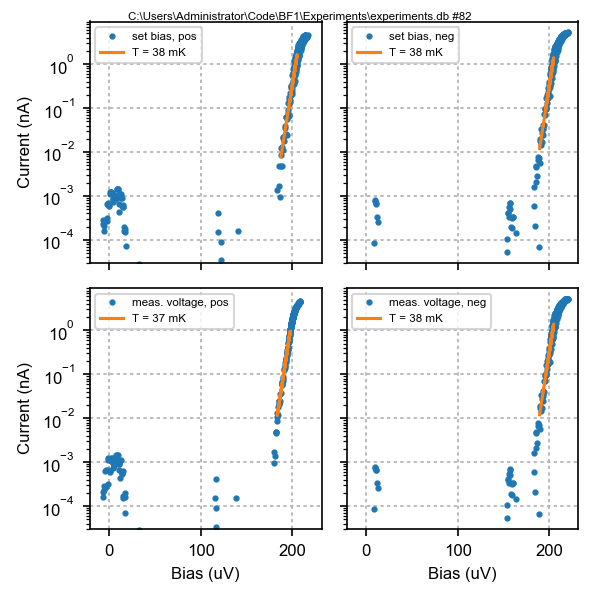

In [719]:
b_plus = b2[b2.size//2+1:]
b_minus = -b2[:b2.size//2]
v_plus = v2[v2.size//2+1:]
v_minus = -v2[:v2.size//2]
i_plus = I_sr[I_sr.size//2:]
i_minus = -I_sr[:I_sr.size//2]
labels = ['set bias, pos', 'set bias, neg', 'meas. voltage, pos', 'meas. voltage, neg']

fitlims = [(197, 210), (197, 210), (197, 210), (197, 210)] 

fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

for i, v, ax, lbl, fl in zip([i_plus, i_minus]*2, [b_plus, b_minus, v_plus, b_minus], axes.reshape(-1), labels, fitlims):
    fitv, fiti, T = fit_linslope(i, v, ilim=(.01,1))
    ax.plot(v, i, 'o', ms=2, label=lbl)
    ax.plot(fitv, fiti, '-', label=f'T = {T*1e3:.0f} mK')
    ax.legend(loc='upper left', fontsize='x-small')
    
    ax.set_yscale('log')
    ax.grid(dashes=[2,2])
    
axes[0,0].set_ylabel('Current (nA)')
axes[1,0].set_ylabel('Current (nA)')
axes[1,0].set_xlabel('Bias (uV)')
axes[1,1].set_xlabel('Bias (uV)')

fig.suptitle(ds_title(dataid), size='x-small')
fig.tight_layout()

basepath = img_basepath(dataid)
if not os.path.exists(os.path.split(basepath)[0]):
    os.makedirs(os.path.split(basepath)[0])
fig.savefig(basepath + 'fit_all_lockin.png', dpi=300)

In [718]:
path, ds = result
dv = get_results_from_db_path(path)
dataid = ds.run_id

b_plus = b2[b2.size//2:]
b_minus = -b2[:b2.size//2]
v_plus = v2[v2.size//2:]
v_minus = -v2[:v2.size//2]
i_plus = i2[i2.size//2:]
i_minus = -i2[:i2.size//2]
labels = ['set bias, pos', 'set bias, neg', 'meas. voltage, pos', 'meas. voltage, neg']

fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

for i, v, ax, lbl in zip([i_plus, i_minus]*2, [b_plus, b_minus, v_plus, b_minus], axes.reshape(-1), labels):
    fitv, fiti, RT = fit_tunnelres(i, v, vlim=(300, 800))
    ax.plot(v, i, 'o', ms=2, label=lbl)
    ax.plot(fitv, fiti, '-', label=f'R$_T$ = {RT:.1f} k$\Omega$')
    ax.legend(loc='upper left', fontsize='x-small')
    
#     ax.set_yscale('log')
    ax.grid(dashes=[2,2])
    
axes[0,0].set_ylabel('Current (nA)')
axes[1,0].set_ylabel('Current (nA)')
axes[1,0].set_xlabel('Bias (uV)')
axes[1,1].set_xlabel('Bias (uV)')

basepath = img_basepath(dataid)
if not os.path.exists(os.path.split(basepath)[0]):
    os.makedirs(os.path.split(basepath)[0])
fig.savefig(basepath + 'fit_RT_all.png', dpi=300)

<IPython.core.display.Javascript object>

TypeError: expected non-empty vector for x

In [455]:
ds = qc.load_by_id(55)


In [693]:
(2.7)*1000/220

12.272727272727273